In [118]:
# importing model and libraries
from darts.models import BlockRNNModel
from darts import TimeSeries
from darts.dataprocessing.transformers.scaler import Scaler
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mae, mse
import torch
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

df = pd.read_csv('ewz_stromabgabe_netzebenen_stadt_zuerich.csv')
df.head(-1)

,Timestamp,Value_NE5,Value_NE7
0,2015-01-01T00:15:00+01:00,22009.8441,46078.667617
1,2015-01-01T00:30:00+01:00,21809.9232,45160.698223
2,2015-01-01T00:45:00+01:00,21854.9834,44388.693804
3,2015-01-01T01:00:00+01:00,21975.9378,44062.418421
4,2015-01-01T01:15:00+01:00,22197.9830,43462.381814
...,...,...,...
321210,2024-02-28T22:45:00+01:00,21576.6549,46157.941393
321211,2024-02-28T23:00:00+01:00,21812.7545,44934.055506
321212,2024-02-28T23:15:00+01:00,21618.9569,43262.693105
321213,2024-02-28T23:30:00+01:00,21381.6378,41562.104460


In [119]:
# Convert 'Timestamp' to datetime and set it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_localize(None)
df.set_index('Timestamp', inplace=True)

# Resample the time series to 1-hour frequency
df = df.resample('1H').mean()

df['Timestamp'] = df.index

df.head(-1)


,Value_NE5,Value_NE7,Timestamp
Timestamp,,,
2014-12-31 23:00:00,21891.583567,45209.353215,2014-12-31 23:00:00
2015-01-01 00:00:00,22186.897125,43185.687737,2015-01-01 00:00:00
2015-01-01 01:00:00,21716.133025,43385.300049,2015-01-01 01:00:00
2015-01-01 02:00:00,21039.683475,40700.715810,2015-01-01 02:00:00
2015-01-01 03:00:00,20283.326025,38530.878445,2015-01-01 03:00:00
...,...,...,...
2024-02-28 18:00:00,27320.854175,66836.470578,2024-02-28 18:00:00
2024-02-28 19:00:00,25585.767675,61801.437960,2024-02-28 19:00:00
2024-02-28 20:00:00,23613.702150,55582.117922,2024-02-28 20:00:00


<Axes: xlabel='Timestamp'>

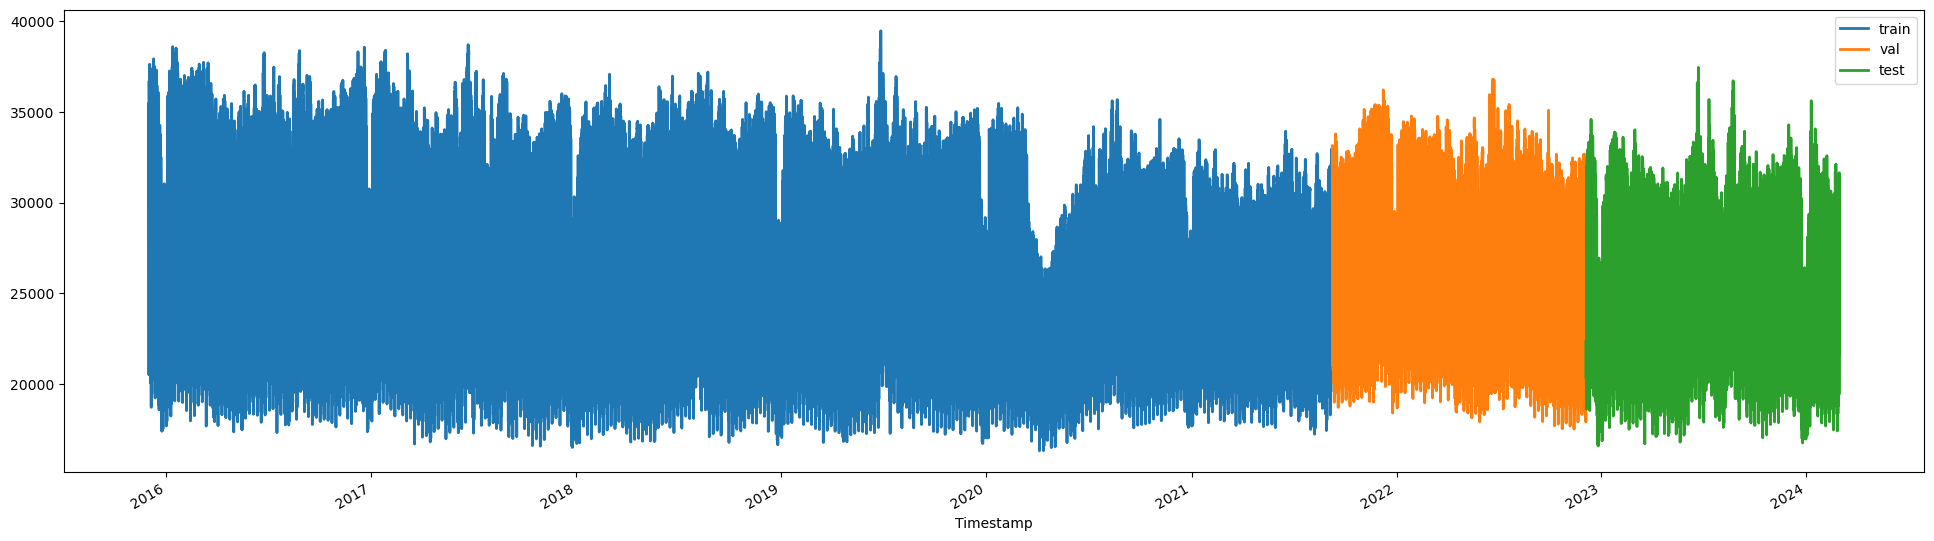

In [120]:
# Convert 'Timestamp' to datetime and removing the time zone information
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_localize(None)
df.set_index('Timestamp', inplace=True)

# Resample the time series to 1-hour frequency
df = df.resample('1H').mean()

df['Timestamp'] = df.index

# Create a Darts TimeSeries object
series = TimeSeries.from_dataframe(df, 'Timestamp', 'Value_NE5')

# Assuming 'series' is your TimeSeries object
train_size = int(len(series) * 0.1)  # Halve the training set

# Split the data
series = series[train_size:]

train, temp = series.split_after(0.7)
val, test = temp.split_after(0.5)

plt.figure(figsize=(24, 6))
train.plot(label="train")
val.plot(label="val")
test.plot(label="test")

<Axes: xlabel='Timestamp'>

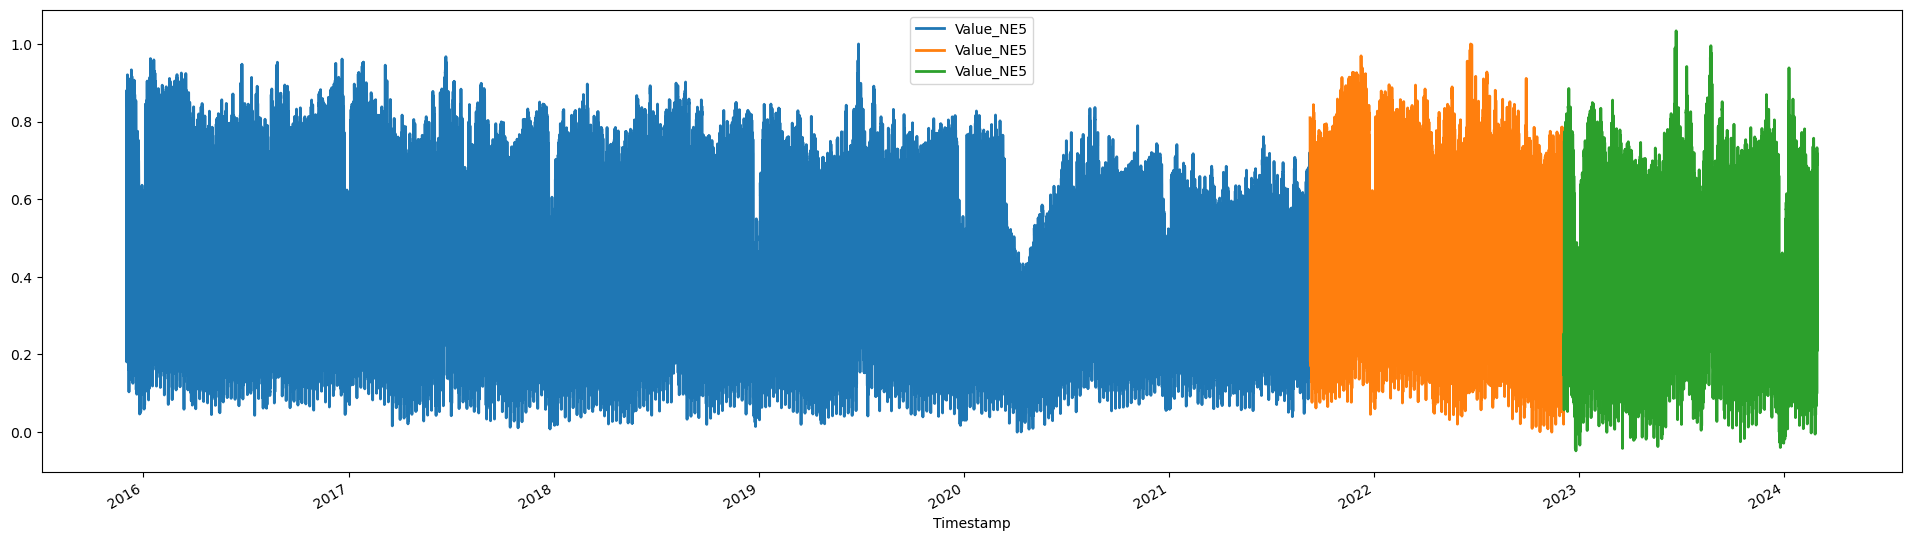

In [121]:
# Scaling the train, val and test sets
scaler = Scaler()
train = scaler.fit_transform(train)
val = scaler.fit_transform(val)
test = scaler.transform(test)

plt.figure(figsize=(24, 6))
train.plot()
val.plot()
test.plot()

In [122]:
common_model_args = {
    "input_chunk_length": 512,
    "output_chunk_length": 256,
    "optimizer_kwargs": {"lr": 1e-3},
    "pl_trainer_kwargs": {
        "gradient_clip_val": 1,
        "max_epochs": 20,
        "accelerator": "auto",
        "callbacks": [],
        "logger": None
    },
    "lr_scheduler_cls": torch.optim.lr_scheduler.ExponentialLR,
    "lr_scheduler_kwargs": {"gamma": 0.999},
    "likelihood": None,
    "save_checkpoints": True,
    "force_reset": True,
    "batch_size": 128,
    "random_state": 42,
}

# Define early stopping arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 3,
    "mode": "min",
    "strict": True,
    "verbose": True,
}

# Defining RNN model parameters
model_rnn_params = {
    "model_name": "rnn",
    "model": "RNN",
    "n_rnn_layers": 6,
    "input_chunk_length": 512,
    "output_chunk_length": 256,
    "optimizer_kwargs": {"lr": 1e-3},
    "batch_size": 128,
    "pl_trainer_kwargs": {
        "gradient_clip_val": 1,
        "max_epochs": 20,
        "accelerator": "auto",
        "callbacks": [],
        "logger": None
    }
}
# Intantiating the RNN model with pre-defined parameters
model_rnn = BlockRNNModel(**model_rnn_params)


models = {
    "RNN": model_rnn
}

In [123]:
import pickle

# Set the log directory where logs will be saved
log_dir = "logs"

# Create a TensorBoardLogger
logger = TensorBoardLogger(log_dir, name="bitbrains_all_models")

# Update your pl_trainer_kwargs
common_model_args['pl_trainer_kwargs']["logger"] = logger

# early stopping needs to get reset for each model
common_model_args['pl_trainer_kwargs']["callbacks"] = [
    EarlyStopping(
        **early_stopping_args,
    )
]

pl_trainer = pl.Trainer(**common_model_args['pl_trainer_kwargs'])

model_rnn.fit(
    series=train,
    val_series=val,
    verbose=True,
)
model_rnn.save(f"models/RNN_electricity2.pt")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 7.2 K 
4 | fc            | Sequential       | 6.7 K 
---------------------------------------------------
13.9 K    Trainable params
0         Non-trainable params
13.9 K    Total params
0.055     Total estimated model params size (MB)


Sanity Checking: |                                                                 | 0/? [00:00<?, ?it/s]

Training: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                      | 0/? [00:00<?, ?it/s]

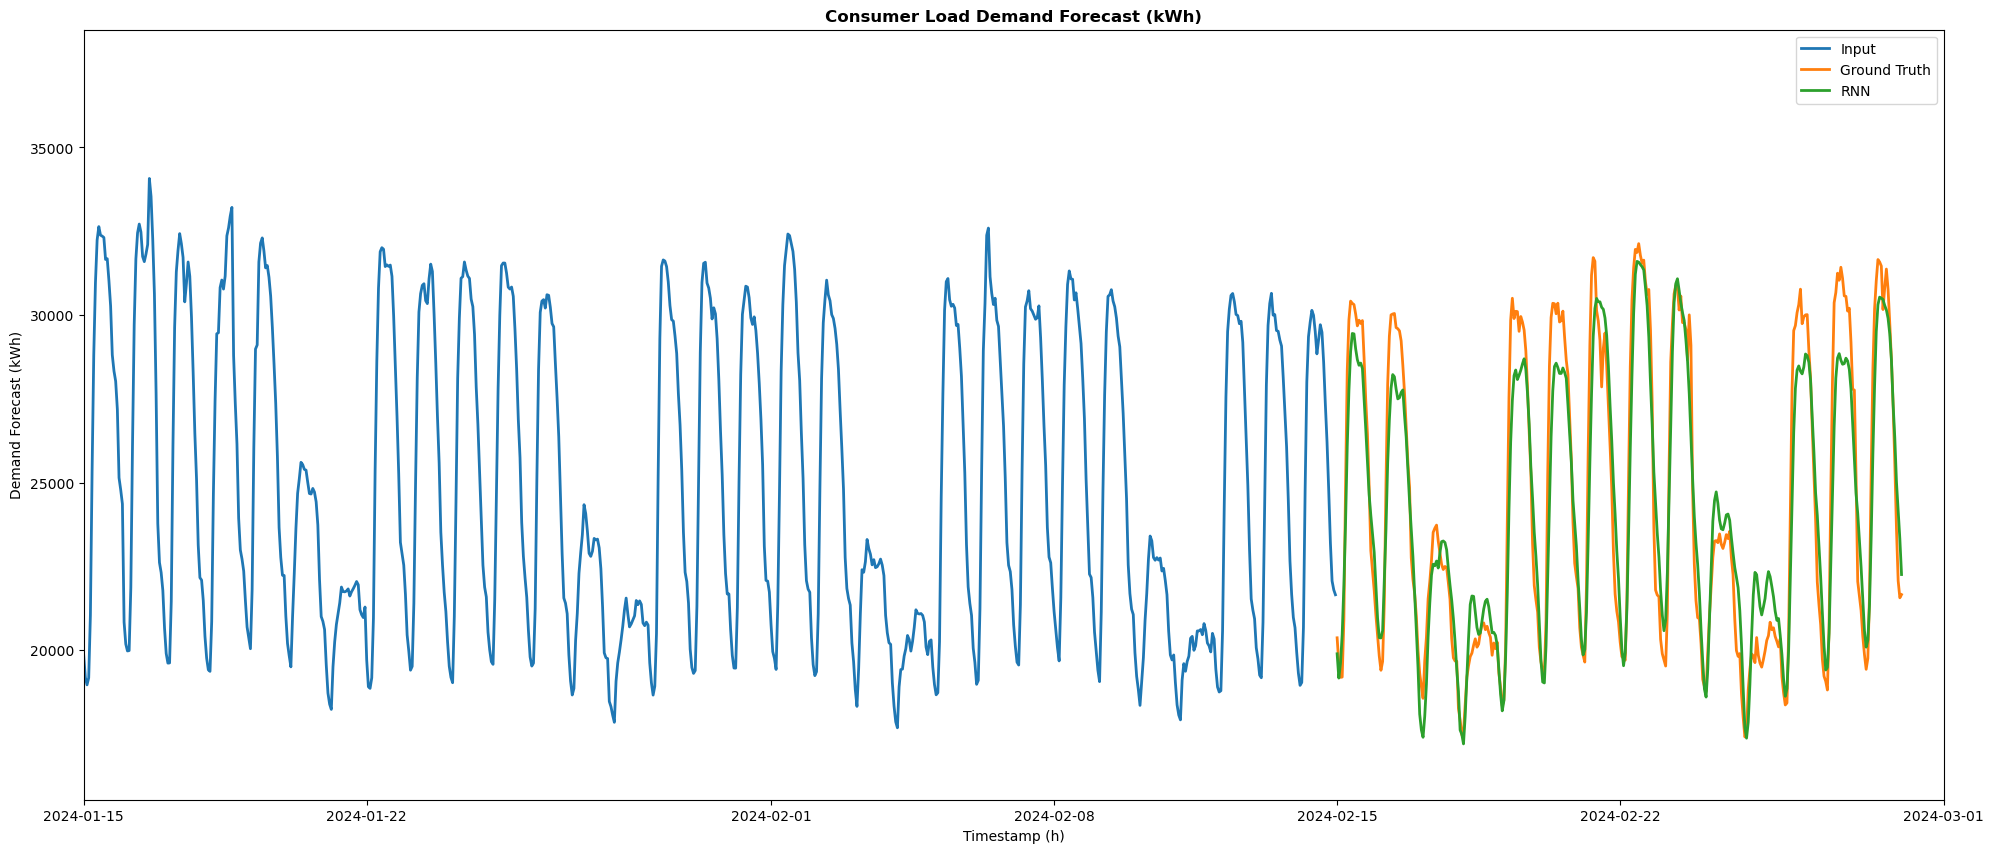

In [124]:
# Loading the saved model
model_rnn = BlockRNNModel.load('models/rnn_electricity2.pt')

# Predicting for the next 2 weeks
pred_steps = 336
pred_input = test[:-pred_steps]

# Performing the prediction
pred_series = model.predict(n=pred_steps, series=pred_input)

# Calculating error rates
mae_result = mae(test, pred_series)
mse_result = mse(test, pred_series)

# Inverse transforming signals to bring them to original scale
pred_series = scaler.inverse_transform(pred_series)
pred_input = scaler.inverse_transform(pred_input)
test = scaler.inverse_transform(test)

# Converting to dataframe
pred_input = pred_input.pd_dataframe()
pred_series = pred_series.pd_dataframe()
test_series = test.pd_dataframe()

# Restoring saved Timestamp column from index values
pred_input["Timestamp"] = pred_input.index
pred_series["Timestamp"] = pred_series.index
test_series["Timestamp"] = test_series.index

# Set the specific start date for plotting
start_date = pd.Timestamp("2024-01-15")
end_date = pd.Timestamp("2024-03-01")

# Defining the size of graph
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(24, 10))
plt.xlim(start_date, end_date)

# Plotting results
plt.plot(pred_input['Timestamp'], pred_input['Value_NE5'], label='Input', linewidth=2)
plt.plot(test_series['Timestamp'][-pred_steps:], test_series['Value_NE5'][-pred_steps:], label='Ground Truth', linewidth=2)
plt.plot(pred_series['Timestamp'], pred_series['Value_NE5'], label='RNN', linewidth=2)

# Adding titles and labels
plt.title('Consumer Load Demand Forecast (kWh)', fontweight='bold')
plt.xlabel('Timestamp (h)')
plt.ylabel('Demand Forecast (kWh)')
plt.legend()

# Turn off grid lines for the x-axis
plt.grid(False, axis='x')

# Reformatting dates axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.savefig('Demand forecasting.png')

In [92]:
print(mae_result) # 0.0577088
print(mse_result) # 0.0051316

0.05770886466643443
0.0051316976692630896
